# The Survey
***

<img align="right" src="https://github.com/3dgeo-heidelberg/helios/blob/dev/h++.png?raw=true" width="300">

This page will give an introduction on using `pyhelios` to access and modify surveys.

`pyhelios` allows you to:

- obtain scanning device characteristics
- calculate the length of a survey
- view and modify the scanner and platform settings at each leg

In [1]:
import math
import pyhelios

In [2]:
import os
os.chdir("..")

In [3]:
pyhelios.loggingDefault()
# build simulation parameters
simBuilder = pyhelios.SimulationBuilder(
    "data/surveys/toyblocks/als_toyblocks.xml", ["assets/"], "output/"
)
simBuilder.setNumThreads(0)
simBuilder.setLasOutput(True)
simBuilder.setZipOutput(True)

# build the survey
simB = simBuilder.build()

SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.02677209999819752 seconds


Once we built a survey, we have numerous options to obtain and change the characteristics of all components of our simulation. Note that after the steps above, simB is a SimulationBuild object. To access the Simulation itself, we have to call simB.sim.

In [4]:
# obtain survey path and name
survey_path = simB.sim.getSurveyPath()
survey = simB.sim.getSurvey()
survey_name = survey.name
print(survey_name)

toyblocks_als


We can also obtain the survey length, i.e. the distance through all waypoints.
If the survey has not been running yet, `survey.getLength()` will return 0.0.
We can calculate the length of a loaded survey of a simulation which was built but not started with `survey.calculateLength()`.


In [5]:
survey.getLength()

0.0

In [6]:
survey.calculateLength()
print(survey.getLength())

400.0


## The Scanner

Let's have a look at the scanner we are using.

In [7]:
scanner = simB.sim.getScanner()
# print scanner characteristics
print(scanner.toString())

Scanner: riegl_vq-880g
Device[0]: riegl_vq-880g
	Average Power: 4 W
	Beam Divergence: 0.3 mrad
	Wavelength: 1064 nm
	Visibility: 23 km



The scanner characteristics can also be accessed individually:

In [8]:
print(
    f"""
{'Device ID:' : <25}{scanner.deviceId : ^8}

{'Average power:' : <25}{scanner.averagePower : <8} W
{'Beam divergence:' : <25}{scanner.beamDivergence : <8} rad
{'Wavelength:' : <25}{scanner.wavelength*1000000000 : <8} nm
{'Scanner visibility:' : <25}{scanner.visibility : <8} km
"""
)


Device ID:               riegl_vq-880g

Average power:           4.0      W
Beam divergence:         0.0003   rad
Wavelength:              1064.0   nm
Scanner visibility:      23.0     km



The scanner has also some more properties:

In [9]:
if scanner.maxNOR == 0:
    max_nor = "unlimited"
else:
    max_nor = scanner.maxNOR


print(
    f"""
{'Number of subsampling rays:' : <30}{scanner.numRays}
{'Pulse length:' : <30}{scanner.pulseLength_ns} ns
{'Supported pulse frequencies:' : <30}{list(scanner.getSupportedPulseFrequencies())} Hz
{'Maximum number of returns:': <30}{max_nor}

"""
)


Number of subsampling rays:   19
Pulse length:                 2.0 ns
Supported pulse frequencies:  [150000, 300000, 600000, 900000] Hz
Maximum number of returns:    unlimited




We can also get information about the scanner head, e.g. the maximum rotation speed in case of TLS scanners.


To demonstrate this, let's load a TLS survey.

In [10]:
pyhelios.loggingDefault()
# build simulation parameters
simBuilder = pyhelios.SimulationBuilder(
    "data/surveys/demo/tls_arbaro_demo.xml", ["assets/"], "output/"
)
simBuilder.setNumThreads(0)
simBuilder.setLasOutput(True)
simBuilder.setZipOutput(True)

# build the survey
simB = simBuilder.build()

SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 3.1580837999936193 seconds


In [11]:
scanner = simB.sim.getScanner()
print(scanner.toString())

Scanner: riegl_vz400
Device[0]: riegl_vz400
	Average Power: 4 W
	Beam Divergence: 0.3 mrad
	Wavelength: 1064 nm
	Visibility: 23 km



In [12]:
head = scanner.getScannerHead()
# get scanner rotation speed and range
print(
    f"""
Max. rotation speed: {round(head.rotatePerSecMax * 180 / math.pi)} degrees per second
"""
)


Max. rotation speed: 60 degrees per second



If we want to obtain information about the scanning mechanism, we have to get the beam deflector.

In [13]:
deflector = scanner.getBeamDeflector()
print(
    f"""
{'Scanner deflector type:': <25}{deflector.getOpticsType() : <8}
{'Scan frequency range:' : <25}{deflector.scanFreqMin} - {deflector.scanFreqMax} Hz
{'Scan angle range:' : <25}{round(deflector.scanAngleMax * 180 / math.pi)}° FOV
"""
)


Scanner deflector type:  POLYGON_MIRROR
Scan frequency range:    3.0 - 120.0 Hz
Scan angle range:        120° FOV



From the beam detector, we get information about, e.g., the accuracy of the scanner.

In [14]:
detector = scanner.getDetector()
print(
    f"""
{'Accuracy:' : <20}{detector.accuracy} m
{'Minimum range:' : <20}{detector.rangeMin} m
{'Maximum range:': <20}{detector.rangeMax} m
"""
)


Accuracy:           0.005 m
Minimum range:      1.5 m
Maximum range:      1.7976931348623157e+308 m



We can also get the scanner full waveform settings.
Like many of the scanner settings, they can be overwritten in the `scannerSettings` of a leg.

In [15]:
print(
    f"""Full waveform settings for {scanner.deviceId}
{'Bin size:' : <25}{scanner.fwfSettings.binSize_ns} ns
{'Window size:' : <25}{scanner.fwfSettings.winSize_ns} ns
{'Beam sample quality:' : <25}{scanner.fwfSettings.beamSampleQuality}
"""
)

Full waveform settings for riegl_vz400
Bin size:                0.2 ns
Window size:             1.25 ns
Beam sample quality:     3



## Legs

Each leg of a survey has scanner settings and platform settings, (cf. survey XML file),
which can be accessed and changed with `pyhelios`.


In [16]:
# get the first leg
leg = simB.sim.getLeg(0)

# scanner settings
print(
    f"""
{'Scanner is active:' : <30}{leg.getScannerSettings().active}
{'Pulse frequency:' : <30}{leg.getScannerSettings().pulseFreq} Hz
{'Scan angle:' : <30}{leg.getScannerSettings().scanAngle * 180 / math.pi}°
{'Minimum vertical angle:' : <30}{leg.getScannerSettings().verticalAngleMin * 180 / math.pi:+.1f}°
{'Maximum vertical angle:' : <30}{round(leg.getScannerSettings().verticalAngleMax * 180 / math.pi):+.1f}°
{'Scan frequency:' : <30}{leg.getScannerSettings().scanFreq} Hz
{'Beam divergence:' : <30}{leg.getScannerSettings().beamDivAngle * 1000} mrad
{'Trajectory time interval:' : <30}{leg.getScannerSettings().trajectoryTimeInterval} s
{'Start angle of head rotation:' : <30}{leg.getScannerSettings().headRotateStart * 180 / math.pi}°
{'Start angle of head rotation:' : <30}{leg.getScannerSettings().headRotateStop * 180 / math.pi}°
{'Rotation speed:' : <30}{leg.getScannerSettings().headRotatePerSec * 180 / math.pi}° per s
"""
)


Scanner is active:            True
Pulse frequency:              100000 Hz
Scan angle:                   100.0°
Minimum vertical angle:       -40.0°
Maximum vertical angle:       +60.0°
Scan frequency:               120.0 Hz
Beam divergence:              0.3 mrad
Trajectory time interval:     1.0 s
Start angle of head rotation: 100.0°
Start angle of head rotation: 225.0°
Rotation speed:               10.0° per s



Scanner Settings and platform settings may be defined through a template.
For this, let's first switch back to the ALS toyblocks demo.

In [17]:
simBuilder = pyhelios.SimulationBuilder(
    "data/surveys/toyblocks/als_toyblocks.xml", ["assets/"], "output/"
)
simBuilder.setNumThreads(0)
simBuilder.setLasOutput(True)
simBuilder.setZipOutput(True)
simB = simBuilder.build()

SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.04844519999460317 seconds


The template can be accessed for a given `ScannerSettings` or `PlatformSettings` instance:

In [18]:
leg = simB.sim.getLeg(0)

ss = leg.getScannerSettings()
if ss.hasTemplate():
    ss_tmpl = ss.getTemplate()
    print(
        f"""
    Scanner template name: {ss_tmpl.id}
    Pulse frequency: {ss_tmpl.pulseFreq/1000} kHz
    """
    )  # Print the pulse frequency defined in the template


    Scanner template name: scanner1
    Pulse frequency: 300.0 kHz
    


In [19]:
ps = leg.getPlatformSettings()
if ps.hasTemplate():
    ps_tmpl = ps.getTemplate()
    print(
        f"""
    {'Platform template name:' : <25}{ps_tmpl.id}
    {'Speed:' : <15}{ps_tmpl.movePerSec} m/s
    {'Altitude:' : <15}{ps_tmpl.z} m
    """
    )


    Platform template name:  platform1
    Speed:         30.0 m/s
    Altitude:      100.0 m
    


We can also change the template.

In [20]:
ps_tmpl.z += 20
print(f"New altitude: {ps_tmpl.z} m")

New altitude: 120.0 m


We can also obtain the position at the current leg:

In [21]:
print(
    f"""
On ground? {leg.getPlatformSettings().onGround}
Position: ({leg.getPlatformSettings().x}, {leg.getPlatformSettings().y}, {leg.getPlatformSettings().z})
"""
)


On ground? False
Position: (-50.0, -50.0, 89.110947)



If we compare the position here to the position in the XML survey file, we notice that they do not match.
The difference is 50 in x direction and 70 in y direction.

When loading a survey, **a shift is applied to the scene and to each leg**. We can obtain this shift:

In [22]:
scene = simB.sim.getScene()
shift = scene.getShift()
print(f"Shift = ({shift.x},{shift.y},{shift.z})")

Shift = (20.0,0.0,10.889053)


Using a for-loop, we can get the positions of all legs.
Note that we add the shift to obtain the true coordinates as specified in the XML-file:


In [23]:
for i in range(simB.sim.getNumLegs()):
    leg = simB.sim.getLeg(i)
    print(
        f"Leg {i}\tposition = "
        f"{leg.getPlatformSettings().x+shift.x},"
        f"{leg.getPlatformSettings().y+shift.y},"
        f"{leg.getPlatformSettings().z+shift.z}\t"
        f"active = {leg.getScannerSettings().active}"
    )

Leg 0	position = -30.0,-50.0,100.0	active = True
Leg 1	position = 70.0,-50.0,100.0	active = False
Leg 2	position = 70.0,0.0,100.0	active = True
Leg 3	position = -30.0,0.0,100.0	active = False
Leg 4	position = -30.0,50.0,100.0	active = True
Leg 5	position = 70.0,50.0,100.0	active = False


We can also use a for-loop to create new legs.
Here an example, where we initiate a simulation with a survey with no legs (`data/surveys/default_survey.xml`) and
then create the legs with Python.

In [24]:
pyhelios.loggingDefault()
default_survey_path = "data/surveys/default_survey.xml"

# default survey with the toyblocks scene (missing platform and scanner definition and not containing any legs)
survey = """
<?xml version="1.0" encoding="UTF-8"?>
<document>
    <survey name="some_survey" scene="data/scenes/toyblocks/toyblocks_scene.xml#toyblocks_scene" platform="data/platforms.xml#copter_linearpath" scanner="data/scanners_als.xml#riegl_vux-1uav">
    </survey>
</document>
"""

with open(default_survey_path, "w") as f:
    f.write(survey)

simBuilder = pyhelios.SimulationBuilder(default_survey_path, ["assets/"], "output/")
simBuilder.setCallbackFrequency(10)
simBuilder.setLasOutput(True)
simBuilder.setZipOutput(True)
simBuilder.setRebuildScene(True)

simB = simBuilder.build()

waypoints = [
    [100.0, -100.0],
    [-100.0, -100.0],
    [-100.0, -50.0],
    [100.0, -50.0],
    [100.0, 0.0],
    [-100.0, 0.0],
    [-100.0, 50.0],
    [100.0, 50.0],
    [100.0, 100.0],
    [-100.0, 100.0],
]
altitude = 100
speed = 150
pulse_freq = 300_000
scan_freq = 200
scan_angle = 37.5 / 180 * math.pi  # convert to rad
shift = simB.sim.getScene().getShift()
for j, wp in enumerate(waypoints):
    leg = simB.sim.newLeg(j)
    leg.serialId = j  # assigning a serialId is important!
    leg.getPlatformSettings().x = wp[0] - shift.x  # don't forget to apply the shift!
    leg.getPlatformSettings().y = wp[1] - shift.y
    leg.getPlatformSettings().z = altitude - shift.z
    leg.getPlatformSettings().movePerSec = speed
    leg.getScannerSettings().pulseFreq = pulse_freq
    leg.getScannerSettings().scanFreq = scan_freq
    leg.getScannerSettings().scanAngle = scan_angle
    leg.getScannerSettings().trajectoryTimeInterval = (
        0.05  # important to get a trajectory output
    )
    if j % 2 != 0:
        leg.getScannerSettings().active = False

SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.11666349999723025 seconds


Let's execute this survey!

In [25]:
import time

start_time = time.time()
simB.start()

if simB.isStarted():
    print("Simulation is started!")

while simB.isRunning():
    duration = time.time() - start_time
    mins = duration // 60
    secs = duration % 60
    print(
        "\r"
        + "Simulation is running since {} min and {} sec. Please wait.".format(
            int(mins), int(secs)
        ),
        end="",
    )
    time.sleep(1)

output = simB.join()
print("\nSimulation has finished.")

Simulation is started!
Simulation is running since 0 min and 0 sec. Please wait.
Simulation has finished.


Now let us also quickly visualize the output. We load the points into numpy arrays using the function `outputToNumpy` and then visualize the point cloud with matplotlib as a simple top view with points coloured by the `hitObjectId`.

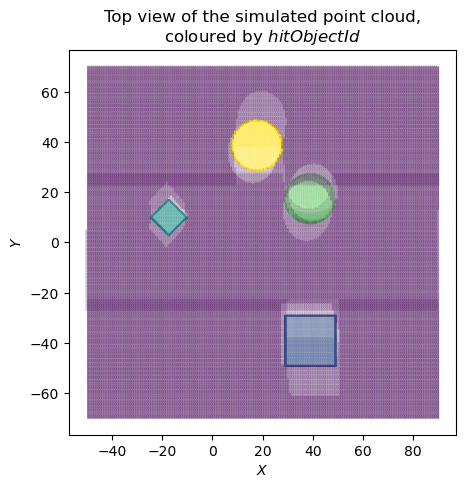

In [26]:
import matplotlib.pyplot as plt

pc, trajectory = pyhelios.outputToNumpy(output)

# Matplotlib figure.
fig = plt.figure(figsize=(5, 5))
# Axes3d axis onto mpl figure.
ax = fig.add_subplot()

# Scatter plot of original and simulated points in different colors
ax.scatter(pc[:, 0], pc[:, 1], c=pc[:, 14], s=0.01)

# Add axis labels.
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.axis("equal")

# Set title.
from textwrap import wrap

title = ax.set_title(
    "\n".join(
        wrap(
            "Top view of the simulated point cloud, coloured by " + r"$hitObjectId$", 40
        )
    )
)

plt.show()